# PyTorch Computer Vision

## Computer Vision Libraries in PyTorch

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## Device Agnostic Code

## Getting a Dataset

In [ ]:
!nvidia-smi

Fri May 26 17:10:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
image, label = train_data[0]
image.to(device)
image.shape, label

(torch.Size([1, 28, 28]), 9)

### Visualize Data

Text(0.5, 1.0, '9')

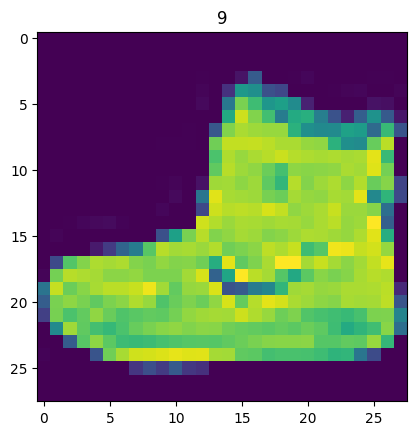

In [ ]:
plt.imshow(image.squeeze())
plt.title(label)

(-0.5, 27.5, 27.5, -0.5)

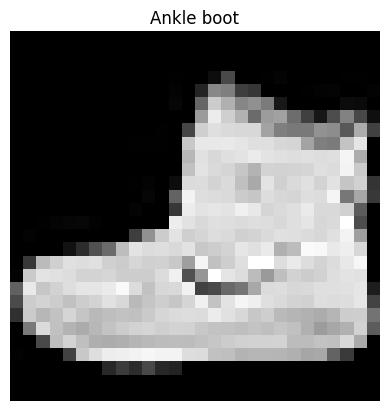

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

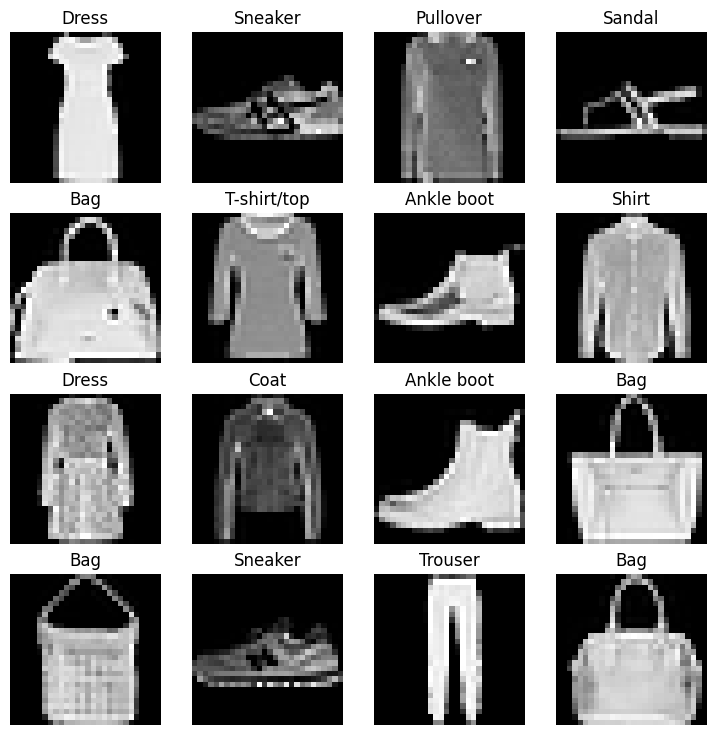

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## Prepare DataLoader 

In [ ]:
from torch.utils.data import DataLoader

# Setup batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fa1b551b790>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa1b75474c0>)

In [ ]:
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [ ]:
# Check out inside of training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

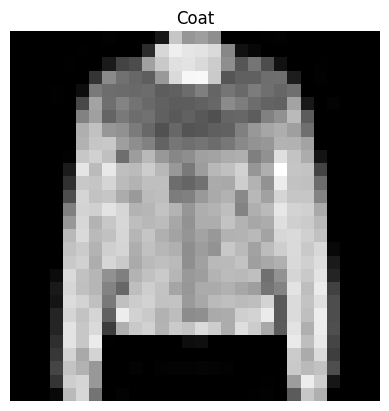

In [ ]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## Baseline Model

In [ ]:
# Device agnostic code
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [ ]:
# Create flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [ ]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1, 1, 28, 28]).to(device)
model_0(dummy_x).shape

torch.Size([1, 10])

### Setup Loss, Optimizer, and Evalutation Metrics

* Loss Function: `nn.CrossEntropyLoss()` for multi-class data
* Optimizer: `torch.optim.SGD`

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists.")
else:
  print("Downloading helper_functions.py.")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### Creating a Function to Time Experiments

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device=device)

Train time on cpu: 0.000 seconds


2.8082000000040352e-05

### Training Model On Batches of Data

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Start the timer
train_time_start= timer()

# Set the number of epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")

  train_loss = 0

  # Loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_pred = model_0(X)

    # Loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:

      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward Pass
      test_pred = model_0(X_test)

      # Loss
      test_loss += loss_fn(test_pred, y_test)

      # Accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    
    # Test loss average per batch
    test_loss /= len(test_dataloader)
    
    # Test acc average per batch
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.4f}| Test loss: {test_loss:.4f}, Test acc: {test_acc:.3f}")

# Training time
train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5870| Test loss: 0.5366, Test acc: 80.711
Epoch: 1
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4724| Test loss: 0.5152, Test acc: 81.440
Epoch: 2
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4523| Test loss: 0.4707, Test acc: 83.466
Train time on cpu: 56.217 seconds


## Make Predictions and Get Model 0 Results

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      # Make predictions
      y_pred = model(X)

      # Accumulate loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    
    # Scale loss and acc to find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [ ]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47066330909729004,
 'model_acc': 83.46645367412141}

## Model 1: Nonlinearity

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### Functionizing Training and Evaluation/Testing Loops

In [ ]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Loop through training batches
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_pred = model(X)

    # Loss and acc per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Divide total train loss/acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc: .2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X_test, y_test in data_loader:

      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward Pass
      test_pred = model(X_test)

      # Loss/Acc
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    
    # Test loss/acc average per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")


In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.05195 | Train acc:  63.76%
Test loss: 0.9753 | Test acc: 65.33%
Epoch: 1
---------
Train loss: 0.76703 | Train acc:  71.76%
Test loss: 0.7051 | Test acc: 73.68%
Epoch: 2
---------
Train loss: 0.67076 | Train acc:  74.57%
Test loss: 0.6908 | Test acc: 73.25%
Train time on cpu: 36.549 seconds


In [ ]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6908059120178223,
 'model_acc': 73.25279552715655}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47066330909729004,
 'model_acc': 83.46645367412141}

## Model 2: Convolutional Neural Network

In [ ]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output Shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output Shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output Shape of classifier: {x.shape}")
    return x

In [ ]:
model_2 = FashionMNISTModelV2(input_shape=1, # number of color channels
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Pass random image through model
rand_image_tensor = torch.randn(size=(1, 28, 28)).to(device)
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
model_2(rand_image_tensor.unsqueeze(0))

tensor([[ 0.0004,  0.0805,  0.0106, -0.0265, -0.0603,  0.0119, -0.0113,  0.0313,
          0.0621,  0.0039]], grad_fn=<AddmmBackward0>)

### Stepping Through `nn.Conv2d()`

In [ ]:
# Create batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:/n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:/n tensor([[[-0.7006,  0.6560,  1.2078,  ...,  0.3986,  0.0430, -1.1951],
         [-0.2192, -1.4149,  0.0901,  ...,  0.4107, -1.1177, -0.0992],
         [-0.1506, -1.0532,  0.4385,  ...,  1.0059,  0.0742,  0.9917],
         ...,
         [-0.9156,  1.8307, -1.7714,  ..., -2.4161,  1.2313, -0.2036],
         [-0.3506, -0.8421,  1.6734,  ...,  1.1609, -0.6004,  1.0618],
         [-0.0313,  0.3210, -1.8409,  ...,  1.4501, -0.0899,  0.3537]],

        [[-1.7413, -1.2743, -1.0058,  ..., -0.8196,  0.4357, -0.7774],
         [-1.1786,  0.2364,  1.3213,  ...,  0.3204,  0.4595, -0.9469],
         [-0.1527, -1.4550, -0.6699,  ...,  2.1754, -0.9118, -1.3964],
         ...,
         [ 0.2729,  0.4264,  0.5722,  ...,  0.9004, -1.3056,  0.3598],
         [ 0.2375,  0.0471,  0.2672,  ...,  1.5382,  1.0207,  1.6930],
         [-2.6345, -0.2899, -0.3766,  ..., -1.1548,  0.1482, -1.4878]],

        [[-

In [ ]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

# Pass data through convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### Stepping through `nn.MaxPool2d()`

In [ ]:
# Create sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

print(f"Shape after convolution: {conv_output.shape}")

test_image_through_max_pool = max_pool_layer(conv_output)
print(f"Shape after max pool and conv: {test_image_through_max_pool.shape}")

Shape after convolution: torch.Size([10, 62, 62])
Shape after max pool and conv: torch.Size([10, 31, 31])


In [ ]:
# Create random tensor with similar number of dimensions to images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor: {random_tensor}\nShape: {random_tensor.shape}")

random_tensor = max_pool_layer(random_tensor)
print(f"Random tensor after max pool: {random_tensor}\nShape: {random_tensor.shape}")

Random tensor: tensor([[[[ 1.1089,  0.8760],
          [ 0.8265, -0.0329]]]])
Shape: torch.Size([1, 1, 2, 2])
Random tensor after max pool: tensor([[[[1.1089]]]])
Shape: torch.Size([1, 1, 1, 1])


### Step Loss Function and Optimizer

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### Training and Testing `model_2`

In [ ]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")

  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  
  train_time_end_model_2 = timer()
  total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                              end=train_time_end_model_2,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.60475 | Train acc:  78.02%
Test loss: 0.4290 | Test acc: 84.62%
Train time on cpu: 40.311 seconds
Epoch: 1
--------
Train loss: 0.37311 | Train acc:  86.66%
Test loss: 0.3925 | Test acc: 85.91%
Train time on cpu: 81.208 seconds
Epoch: 2
--------
Train loss: 0.33627 | Train acc:  87.89%
Test loss: 0.3410 | Test acc: 87.58%
Train time on cpu: 122.070 seconds


In [ ]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3410469889640808,
 'model_acc': 87.57987220447285}

## Compare Model Results and Training Time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.470663,83.466454
1,FashionMNISTModelV1,0.690806,73.252796
2,FashionMNISTModelV2,0.341047,87.579872


In [ ]:
compare_results["training_time"] = [total_train_time_model_0,
                                   total_train_time_model_1,
                                   total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.470663,83.466454,56.217083
1,FashionMNISTModelV1,0.690806,73.252796,36.549351
2,FashionMNISTModelV2,0.341047,87.579872,122.069949


Text(0, 0.5, 'model')

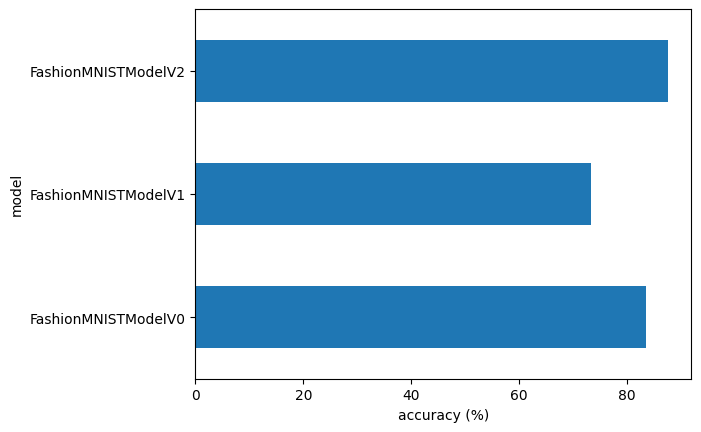

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## Make and Evaluate Random Predictions

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward Pass
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Put on CPU for matplotlib
      pred_probs.append(pred_prob.cpu())

    # Stack pred_probs to turn list into tensor
    return torch.stack(pred_probs)

In [ ]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (Pullover)


Text(0.5, 1.0, 'Pullover')

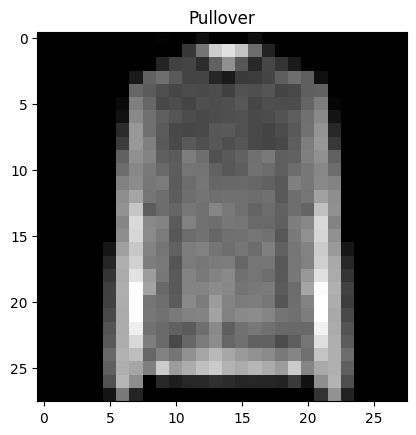

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[1.3751e-02, 2.2947e-04, 5.4928e-01, 3.2106e-02, 1.2873e-01, 4.1344e-04,
         2.7357e-01, 4.1128e-06, 1.9048e-03, 1.1731e-05],
        [6.0173e-08, 6.4607e-09, 1.6150e-07, 7.4651e-07, 7.7195e-09, 3.2201e-05,
         1.3114e-07, 1.3566e-04, 9.7956e-07, 9.9983e-01]])

In [ ]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 9, 1, 1, 2, 1, 8, 7, 3])

### Plot Predictions

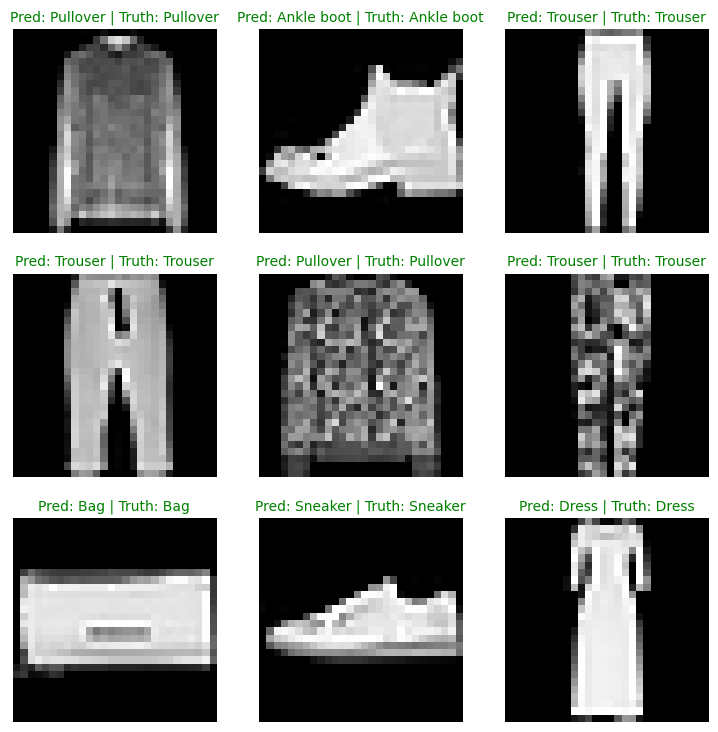

In [ ]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i + 1)

  # Plot target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find prediction label in text form
  pred_label = class_names[pred_classes[i]]

  # Get truth label in text form
  truth_label = class_names[test_labels[i]]

  # Create title of plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

## Confusion Matrix
1. Make predictions with trained model on test dataset
2. Make confusion matrix using `torchmetrics.ConfusionMatrix`
3. Plot confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
from tqdm.auto import tqdm

# Make predictions
y_preds = []
model_2.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="making predictions..."):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_logit = model_2(X)

    # Logits -> probs -> labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    y_preds.append(y_pred.cpu())
  
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 4, 4, 6, 5, 7])

In [ ]:
len(y_pred_tensor)

10000

In [ ]:
try: 
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.7 MB/s eta 0:00:00
mlxtend version: 0.22.0


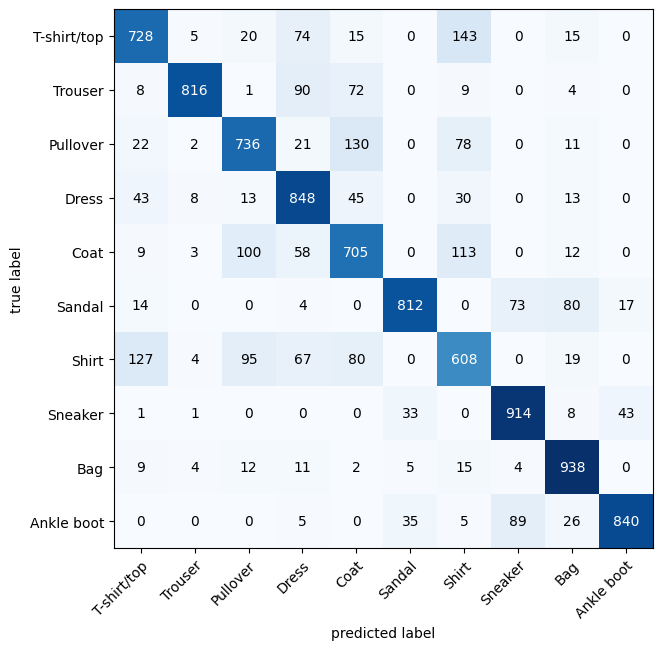

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confuision instance
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## Save and Load Best Model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


### Load saved model

In [ ]:
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=10)

# Load in saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2 = loaded_model_2.cpu()

### Evaluate Loaded Model

In [ ]:
loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3410469889640808,
 'model_acc': 87.57987220447285}

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3410469889640808,
 'model_acc': 87.57987220447285}

In [ ]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]))

tensor(True)